In [27]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score


In [ ]:
# Load the data from CSV file
df = pd.read_csv("bankruptcy.csv")
df.head()

In [ ]:
# Split the data into training and testing sets
X = df.drop("Bankrupt?", axis=1)
y = df["Bankrupt?"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Building a Neural Network Model

In [ ]:
# Build the neural network model
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

### Seeing the accuracy of our model(s)

In [ ]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test, y_test)

# Print the accuracy
print("Accuracy:", accuracy)

### Trying to do some visualisation of the data here


In [ ]:
# Create a correlation matrix
corr_matrix = df.corr()

# Generate a heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm')

# Show the plot
plt.show()

In [ ]:
# Find the top 10 features with highest absolute correlation values with Bankrupt? column
num_features = 10
corr_with_bankrupt = corr_matrix["Bankrupt?"].abs().sort_values(ascending=False)
top_corr_features = corr_with_bankrupt[1:num_features+1].index.tolist()

# Create a heatmap of top 10 features with highest absolute correlation values
sns.set(style="white")
plt.figure(figsize=(10,8))
sns.heatmap(df[top_corr_features].corr(), annot=True, cmap="YlGnBu")
plt.title("Top 10 features with highest absolute correlation values with Bankrupt?", fontsize=16)
plt.show()

In [ ]:
# Create scatter plot for each combination of top features
# for i in range(len(top_corr_features)):
#     for j in range(i+1, len(top_corr_features)):
#         feature1 = top_corr_features[i]
#         feature2 = top_corr_features[j]
#         sns.jointplot(x=feature1, y=feature2, data=df, kind='reg')
#         plt.show()

[Text(669.6, 1087.2, " Net Income to Stockholder's Equity <= 0.834\ngini = 0.06\nsamples = 5455\nvalue = [5286, 169]\nclass = Not Bankrupt"),
 Text(334.8, 652.32, ' Interest Expense Ratio <= 0.63\ngini = 0.463\nsamples = 192\nvalue = [122, 70]\nclass = Not Bankrupt'),
 Text(167.4, 217.44000000000005, 'gini = 0.465\nsamples = 49\nvalue = [18, 31]\nclass = Bankrupt'),
 Text(502.20000000000005, 217.44000000000005, 'gini = 0.397\nsamples = 143\nvalue = [104, 39]\nclass = Not Bankrupt'),
 Text(1004.4000000000001, 652.32, ' Borrowing dependency <= 0.379\ngini = 0.037\nsamples = 5263\nvalue = [5164, 99]\nclass = Not Bankrupt'),
 Text(837.0, 217.44000000000005, 'gini = 0.012\nsamples = 4626\nvalue = [4597, 29]\nclass = Not Bankrupt'),
 Text(1171.8, 217.44000000000005, 'gini = 0.196\nsamples = 637\nvalue = [567, 70]\nclass = Not Bankrupt')]

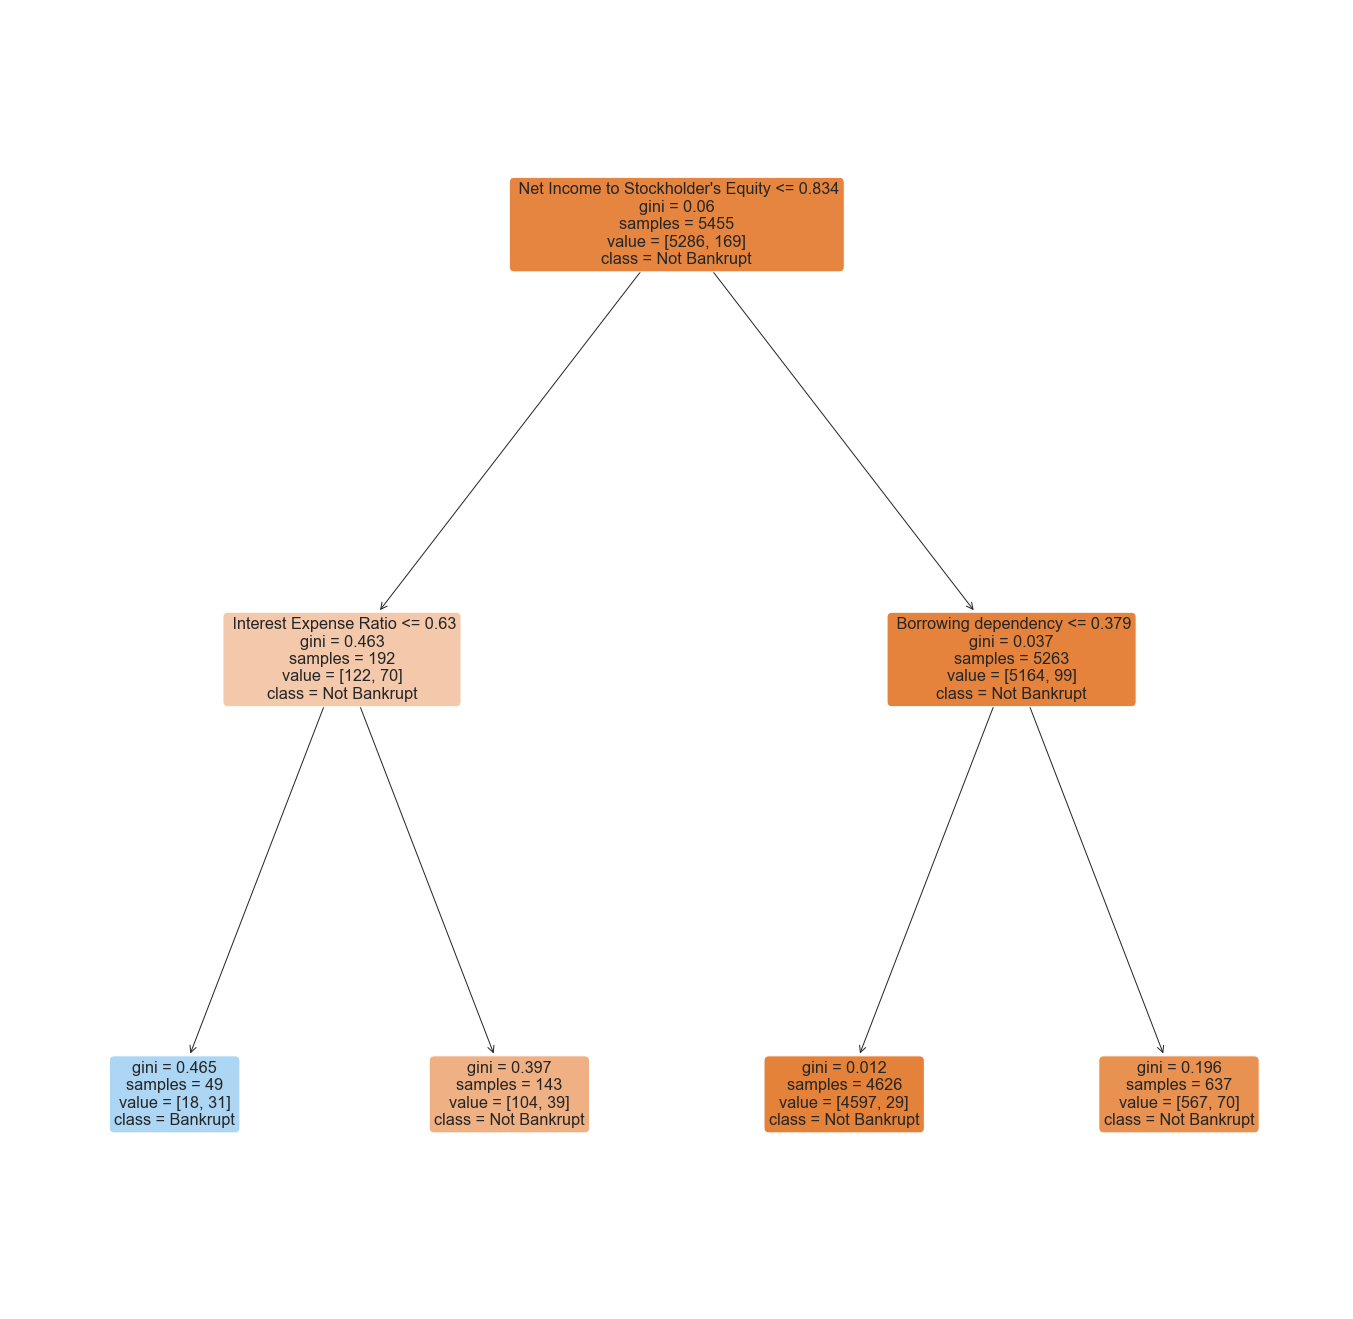

In [25]:
dectree = DecisionTreeClassifier(max_depth=2)
dectree.fit(X_train, y_train)

f = plt.figure(figsize=(24,24))
plot_tree(dectree, filled=True, rounded=True, 
          feature_names=X.columns, 
          class_names=["Not Bankrupt","Bankrupt"])

In [35]:
# Evaluate the accuracy of the model
y_pred = dectree.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of the model: {:.2f}%".format(accuracy*100))


Accuracy of the model: 96.26%
